# Домашнее задание
## Почувствуй мощь трансформеров в бою
В качестве данных выберете возьмите датасет RuCola для русского языка https://github.com/RussianNLP/RuCoLA (в качестве train возьмите in_domain_train.csv, а в качестве теста in_domain_dev.csv)
Разбейте in_domain_train на train и val
Зафайнтьюньте и протестируйте RuBert или RuRoBerta на данной задаче (можно взять любую предобученную модель руберт с сайта huggingface. Например, ruBert-base/large https://huggingface.co/sberbank-ai/ruBert-base / https://huggingface.co/sberbank-ai/ruBert-large или rubert-base-cased https://huggingface.co/DeepPavlov/rubert-base-cased, ruRoberta-large https://huggingface.co/sberbank-ai/ruRoberta-large, xlm-roberta-base https://huggingface.co/xlm-roberta-base)
Возьмите RuGPT3 base или large и решите данное задание с помощью методов few-/zero-shot
а) переберите несколько вариантов затравок
б) протестируйте различное число few-shot примеров (0, 1, 2, 4)
Обучите и протестируйте модель RuT5 на данной задаче (пример finetun’а можете найти здесь https://github.com/RussianNLP/RuCoLA/blob/main/baselines/finetune_t5.py)
Сравните полученные результаты


Критерии оценки:
Файнтьюн БЕРТА - 3 балла
Реализация few-/zero-shot c GPT3 - 4 балла
Файнтьюн RuT5 - 3 балла

In [1]:
!pip install wget evaluate utils

In [2]:
!pip install auto_gptq

In [3]:
!git clone https://github.com/RussianNLP/RuCoLA.git

fatal: destination path 'RuCoLA' already exists and is not an empty directory.


## Import Dependencies

In [4]:
import numpy as np
import pandas as pd

import torch
from torch.optim import AdamW
from torch.utils.data import TensorDataset, random_split, DataLoader, RandomSampler, SequentialSampler

import transformers
from transformers import (
    BertTokenizer,
    BertForSequenceClassification,
    AutoTokenizer,
    AutoModelForCausalLM,
    AutoModelForSeq2SeqLM,
    DataCollatorForSeq2Seq,
    Seq2SeqTrainingArguments,
    Seq2SeqTrainer
)

from auto_gptq import AutoGPTQForCausalLM

from sklearn.metrics import matthews_corrcoef

import random

from tqdm import tqdm

import matplotlib.pyplot as plt

from datasets import Dataset, DatasetDict

from datasets import load_metric
from functools import partial

In [5]:
# If there's a GPU available...
if torch.cuda.is_available():

    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4



## RuBERT Fine-Tuning

In [6]:
train_path = "RuCoLA/data/in_domain_train.csv"
test_path = "RuCoLA/data/in_domain_dev.csv"

train_df = pd.read_csv(train_path, index_col="id")
test_df = pd.read_csv(test_path, index_col="id")

print('Number of training sentences: {:,}\n'.format(train_df.shape[0]))
print('Number of test sentences: {:,}\n'.format(test_df.shape[0]))

train_df.head()

Number of training sentences: 7,869

Number of test sentences: 983



,sentence,acceptable,error_type,detailed_source
id,,,,
0,"Вдруг решетка беззвучно поехала в сторону, и н...",1,0,Paducheva2004
1,Этим летом не никуда ездили.,0,Syntax,Rusgram
2,Только Иван выразил какую бы то ни было готовн...,1,0,Paducheva2013
3,"Теперь ты видишь собственными глазами, как тут...",1,0,Paducheva2010
4,На поверку вся теория оказалась полной чепухой.,1,0,Paducheva2010


In [7]:
model_tag = 'DeepPavlov/rubert-base-cased'
model = BertForSequenceClassification.from_pretrained(
    model_tag,
    num_labels=2,
    output_attentions = False,
    output_hidden_states = False,
    )
model.to(device);

optimizer = AdamW(
    model.parameters(),
    lr=2e-5
)

tokenizer = BertTokenizer.from_pretrained(model_tag, do_lower_case=False)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
def create_dataloaders_from_df(tokenizer, train_df, test_df, x_key="sentence", y_key="acceptable", valid_size=0.1, batch_size=32, new_sent_len=64, is_t5=False):
  main_sentences = train_df[x_key]
  main_labels = train_df[y_key]

  main_input_ids = []
  main_att_masks = []

  for sent in main_sentences:
    encoded_dict = tokenizer.encode_plus(
        sent,
        add_special_tokens = True,
        max_length=new_sent_len,
        padding="max_length",
        return_attention_mask = True,
        return_tensors = 'pt',
    )

    main_input_ids.append(encoded_dict['input_ids'])
    main_att_masks.append(encoded_dict['attention_mask'])

  main_input_ids = torch.cat(main_input_ids, dim=0)
  main_att_masks = torch.cat(main_att_masks, dim=0)
  main_labels = torch.tensor(main_labels)

  main_dataset = TensorDataset(main_input_ids, main_att_masks, main_labels)

  valid_len = int(len(main_dataset) * valid_size)
  train_len = len(main_dataset) - valid_len

  train_dataset, valid_dataset = random_split(main_dataset, [train_len, valid_len])

  print(f"Размер тренировочной выборки - {len(train_dataset)}")
  print(f"Размер валидационной выборки - {len(valid_dataset)}")

  train_dataloader = DataLoader(
      train_dataset,
      sampler=RandomSampler(train_dataset),
      batch_size=batch_size,
      drop_last=True
  )

  valid_dataloader = DataLoader(
      valid_dataset,
      sampler=SequentialSampler(valid_dataset),
      batch_size=batch_size
  )

  test_input_ids = []
  test_att_masks = []

  test_sentences = test_df[x_key]
  test_labels = test_df[y_key]

  for sent in test_sentences:
    encoded_dict = tokenizer.encode_plus(
        sent,
        add_special_tokens=True,
        max_length=new_sent_len,
        padding='max_length',
        return_attention_mask=True,
        return_tensors='pt'
    )

    test_input_ids.append(encoded_dict['input_ids'])
    test_att_masks.append(encoded_dict['attention_mask'])

  test_input_ids = torch.cat(test_input_ids, dim=0)
  test_att_masks = torch.cat(test_att_masks, dim=0)
  test_labels = torch.tensor(test_labels)

  test_dataset = TensorDataset(test_input_ids, test_att_masks, test_labels)
  test_dataloader = DataLoader(
      test_dataset,
      sampler=SequentialSampler(test_dataset),
      batch_size=batch_size
  )


  return train_dataloader, valid_dataloader, test_dataloader

def flat_acc(preds, labels):
  preds_flat = np.argmax(preds, axis=1).flatten()
  labels_flat = labels.flatten()

  return np.sum(preds_flat == labels_flat) / len(labels_flat)

In [9]:
train_dataloader, val_dataloader, prediction_dataloader = create_dataloaders_from_df(tokenizer, train_df, test_df)

Размер тренировочной выборки - 7083
Размер валидационной выборки - 786


In [10]:
for sample in val_dataloader:
  print(sample[1][0])
  break

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


### Обучение

In [11]:
# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

train_loss_list = []
valid_loss_list = []

train_acc_list = []
valid_acc_list = []

epochs = 3

for epoch in range(epochs):
  total_train_loss = 0
  total_train_acc = 0

  model.train()
  pbar = tqdm(enumerate(train_dataloader), total=len(train_dataloader))

  for step, sample in pbar:
    model.zero_grad()

    input_ids, attention_masks, labels = sample

    input_ids = input_ids.to(device)
    attention_masks = attention_masks.to(device)
    labels = labels.to(device)

    res = model(
        input_ids=input_ids,
        token_type_ids=None,
        attention_mask=attention_masks,
        labels=labels
    )

    loss = res['loss']
    logits = res['logits']

    curr_loss = loss.item()
    total_train_loss += curr_loss

    curr_acc = flat_acc(logits.cpu().detach().numpy(), labels.cpu().numpy())
    total_train_acc += curr_acc

    pbar.set_description(f"Train Loss: {curr_loss:.4f}; Train Accuracy: {curr_acc:.4f}")

    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optimizer.step()

  avg_train_loss = total_train_loss / len(train_dataloader)
  avg_train_acc = total_train_acc / len(train_dataloader)

  train_loss_list.append(avg_train_loss)
  train_acc_list.append(avg_train_acc)

  print(f"Avg Train Loss: {avg_train_loss:.4f}\nAvg Train Acc: {avg_train_acc:.4f}\n")

  pbar = tqdm(enumerate(val_dataloader), total=len(val_dataloader))

  total_valid_loss = 0
  total_valid_acc = 0

  model.eval()

  with torch.no_grad():

    for step, sample in pbar:
      input_ids, attention_masks, labels = sample

      input_ids = input_ids.to(device)
      attention_masks = attention_masks.to(device)
      labels = labels.to(device)

      res = model(
        input_ids=input_ids,
        token_type_ids=None,
        attention_mask=attention_masks,
        labels=labels
      )

      loss = res['loss']
      logits = res['logits']

      curr_loss = loss.item()
      total_valid_loss += curr_loss

      curr_acc = flat_acc(logits.cpu().detach().numpy(), labels.cpu().numpy())
      total_valid_acc += curr_acc

      pbar.set_description(f"Valid Loss: {curr_loss:.4f}; Valid Accuracy: {curr_acc:.4f}")

  avg_valid_loss = total_valid_loss / len(val_dataloader)
  avg_valid_acc = total_valid_acc / len(val_dataloader)

  valid_loss_list.append(avg_valid_loss)
  valid_acc_list.append(avg_valid_acc)

  print(f"Avg Valid Loss: {avg_valid_loss:.4f}\nAvg Valid Acc: {avg_valid_acc:.4f}\n")

Train Loss: 0.5690; Train Accuracy: 0.7188: 100%|██████████| 221/221 [01:18<00:00,  2.80it/s]


Avg Train Loss: 0.5488
Avg Train Acc: 0.7540



Valid Loss: 0.5943; Valid Accuracy: 0.7222: 100%|██████████| 25/25 [00:03<00:00,  7.89it/s]


Avg Valid Loss: 0.5554
Avg Valid Acc: 0.7489



Train Loss: 0.4930; Train Accuracy: 0.7812: 100%|██████████| 221/221 [01:20<00:00,  2.73it/s]


Avg Train Loss: 0.4712
Avg Train Acc: 0.7978



Valid Loss: 0.4769; Valid Accuracy: 0.7222: 100%|██████████| 25/25 [00:03<00:00,  7.95it/s]


Avg Valid Loss: 0.5167
Avg Valid Acc: 0.7564



Train Loss: 0.2833; Train Accuracy: 0.8438: 100%|██████████| 221/221 [01:20<00:00,  2.75it/s]


Avg Train Loss: 0.3357
Avg Train Acc: 0.8579



Valid Loss: 0.4906; Valid Accuracy: 0.7778: 100%|██████████| 25/25 [00:03<00:00,  8.08it/s]

Avg Valid Loss: 0.6365
Avg Valid Acc: 0.7761



### Train and Valid Loss and Accuracy

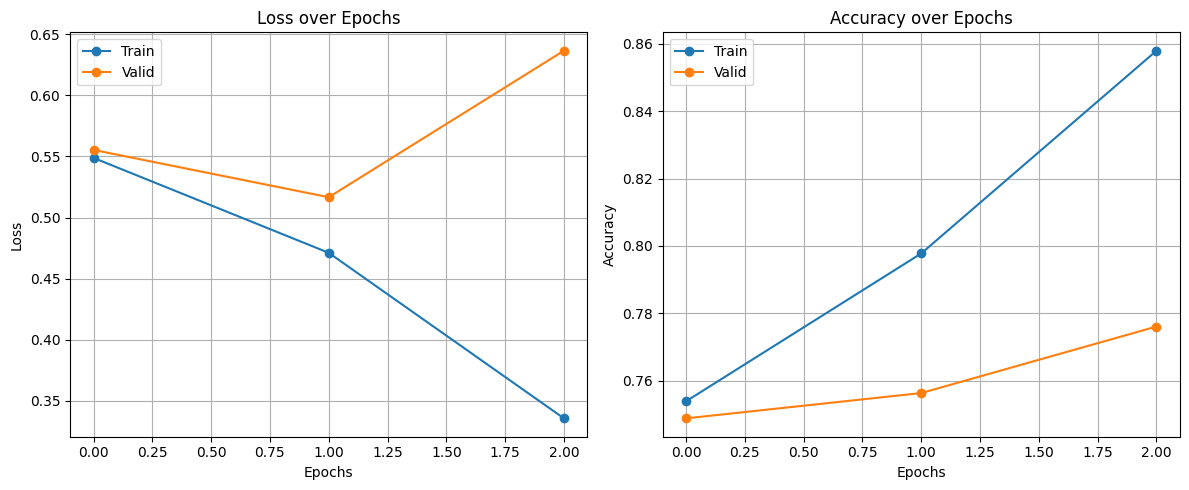

In [12]:
def plot_loss_and_accuracy(epochs, train_loss_list, valid_loss_list, train_acc_list, valid_acc_list):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.title("Loss over Epochs")
    plt.plot(range(epochs), train_loss_list, marker="o", label="Train")
    plt.plot(range(epochs), valid_loss_list, marker="o", label="Valid")
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.title("Accuracy over Epochs")
    plt.plot(range(epochs), train_acc_list, marker="o", label="Train")
    plt.plot(range(epochs), valid_acc_list, marker="o", label="Valid")
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_loss_and_accuracy(epochs, train_loss_list, valid_loss_list, train_acc_list, valid_acc_list)

### Evaluation on Test data

In [13]:
# Put model in evaluation mode
model.eval()

# Tracking variables
predictions , true_labels = [], []

# Predict
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)

  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch

  # Telling the model not to compute or store gradients, saving memory and
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None,
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

In [14]:
def calc_mcc_from_logits(true_labels, predictions):
  matthews_set = []

  # For each input batch...
  for i in range(len(true_labels)):

    # The predictions for this batch are a 2-column ndarray (one column for "0"
    # and one column for "1"). Pick the label with the highest value and turn this
    # in to a list of 0s and 1s.
    pred_labels_i = np.argmax(predictions[i], axis=1).flatten()

    # Calculate and store the coef for this batch.
    matthews = matthews_corrcoef(true_labels[i], pred_labels_i)
    matthews_set.append(matthews)

  flat_predictions = np.concatenate(predictions, axis=0)

  # For each sample, pick the label (0 or 1) with the higher score.
  flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

  # Combine the correct labels for each batch into a single list.
  flat_true_labels = np.concatenate(true_labels, axis=0)

  # Calculate the MCC
  mcc = matthews_corrcoef(flat_true_labels, flat_predictions)

  print('Total MCC: %.3f' % mcc)

In [15]:
calc_mcc_from_logits(true_labels, predictions)

Total MCC: 0.411


## Few-shot zero-shot RuGPT3

In [16]:
def calc_loss(phrase: str,
                        tokenizer,
                        model):

    phrase = tokenizer.encode(phrase.lower()) #
    # Если длина фразы 1 токен, то дальше ошибка вылезет :(
    if len(phrase) == 1:
         phrase.append(tokenizer.eos_token_id)
    phrase = torch.tensor(phrase, device=device)
    phrase = phrase.unsqueeze(0)  # .repeat(num_samples, 1)
    with torch.no_grad():
        loss = model(phrase, labels=phrase)

    return loss[0].item()

def get_loss_num(text):
    loss = calc_loss(phrase=text, model=model, tokenizer=tokenizer)
    return loss

def create_prompt_string(sent, label, left_text="В следующем предложении есть ошибка? "):
    right_text = "нет" if label == 1 else "да"
    return f"{left_text}{sent} Ответ: {right_text}."

In [17]:
def gpt_eval(model, tokenizer, sentences, labels, shots=[]):
    if shots:
        few_shots = [create_prompt_string(sample[0], sample[1]) for sample in shots]
        prompt_prefix = "\n".join(few_shots) + "\n"
    else:
        prompt_prefix = ""

    model.eval()
    global predictions
    global true_labels
    predictions = []
    true_labels = []

    for sent, label in zip(sentences, labels):
        false_sent_loss = calc_loss(prompt_prefix + create_prompt_string(sent, 0), tokenizer, model)
        true_sent_loss = calc_loss(prompt_prefix + create_prompt_string(sent, 1), tokenizer, model)

        loss_tuple = (false_sent_loss, true_sent_loss)
        predictions.append(np.argmin(loss_tuple))
        true_labels.append(label)

    mcc = matthews_corrcoef(true_labels, predictions)
    print(f"Matthews correlation coefficient on shots={len(shots)}: {mcc}")

In [18]:
model_name = 'IlyaGusev/rugpt3medium_sum_gazeta'

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)
model.cuda()

shots = [
    ("Собака лает на прохожих.", 1),
    ("Человек идет в и магазине.", 0),
    ("Они гулять по парке.", 0),
    # ("Книга лежит на столе.", 1),
    # ("Книга любить читать.", 0)
]

gpt_eval(
    model=model,
    tokenizer=tokenizer,
    sentences=test_df.sentence,
    labels=test_df.acceptable,
    shots=shots
)

gpt_eval(
    model=model,
    tokenizer=tokenizer,
    sentences=test_df.sentence,
    labels=test_df.acceptable,
)

tokenizer_config.json:   0%|          | 0.00/678 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.61M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.98M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/105 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/986 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.52G [00:00<?, ?B/s]

Matthews correlation coefficient on shots=3: 0.08441909656772244
Matthews correlation coefficient on shots=0: 0.018980328290427062


### Сводка по Few-shot Zero-shot GPT3

В данном случае у промптов была следующая структура:

> Предложение далее корректное? {Предложение} Ответ: {да/нет}.

Пробовал другие структуры , по типу
> Следующее предложение корректное? {Предложение} Ответ: {да/нет}.

> Следующее предложение содержит ошибки? {Предложение} Ответ: {нет/да}.

Особо никаких результатов не принесло. Из моделей ai-forever/rugpt3{small/medium/large}_based_on_gpt2 лучший результат показала large. Показатели следующие:
Структура промпта:
> В следующем предложении есть ошибка? {Предложение} Ответ: {нет/да}.

Shot'ы:
```
shots = [
    ("Собака лает на прохожих.", 1),
    ("Человек идет в и магазине.", 0),
    ("Они гулять по парку.", 0),
    ("Книга лежит на столе.", 1),
    ("Книга любить читать.", 0)
]
```

Показатель MCC на тестовой выборке: 0.06881427127451528

Это не особо хороший результат(где-то 55/100, т.к. коэф. корреляции Мэтьюса лежит в диапазоне от -1 до 1, где 0 - случайное подкидывание монетки), но хотя бы выше, чем если просто случайно выбирать 0 или 1.

Остальные попытки с разными моделями/промтами/кол-вом промптов не дали лучшего результата.

Пробовал IlyaGusev/rugpt3medium_sum_gazeta -  это просто medium модель сбера, которую дообучили на задаче суммаризации газет.
```
shots = [
    ("Собака лает на прохожих.", 1),
    ("Человек идет в и магазине.", 0),
    ("Они гулять по парке.", 0),
]
```
Показатель MCC на тестовой выборке: 0.08441909656772244

Уже получше, но всё равно не очень хороший результат.


Однако инференс ооооочень долгий - порядка 30 минут. Для сравнения, на small-medium-large моделях от Сбера инференс длился 1-2 минуты.


По поводу экспериментов с количеством few-shot примеров и их разнообразием: если много примеров - плохо (видимо уже зашумляется промпт и модель плохо реагирует на целевой), а разнообразие примеров тяжеловато подобрать, потому что русский язык весьма сложный, нужно охватить синтаксические, семантические и морфологические ошибки(и в каждой из этих групп весьма много примеров).

Также модель весьма сильно реагирует на то, с каким количеством ошибок подаётся ошибочное предложение для примера(оптимальное - две, т.е если больше или меньше, уже отрицательно сказывается на результате).


В целом - надо просто иметь хорошие модельки(что-то типо GPT 3.5 от Сбера) - и немного поэкспериментировать с промптами, и в таком случае, несложные задачи, подобные этой, можно вполне решать.

А с моделями типо gpt-2 я считаю такое их применение нецелесообразным (видимо, слабоватые модели для такого серьёзного подхода)






## RuT5 Fine-Tuning

In [19]:
def compute_metrics(p, tokenizer):
    string_preds = tokenizer.batch_decode(p.predictions, skip_special_tokens=True)
    int_preds = [1 if prediction == pos_label else 0 for prediction in string_preds]

    labels = np.where(p.label_ids != -100, p.label_ids, tokenizer.pad_token_id)
    string_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    int_labels = []

    for string_label in string_labels:
        if string_label == pos_label:
            int_labels.append(1)
        elif string_label == neg_label or string_label == "":
            int_labels.append(0)

    acc_result = acc.compute(predictions=int_preds, references=int_labels)
    mcc_result = mcc.compute(predictions=int_preds, references=int_labels)

    result = {"accuracy": acc_result["accuracy"], "mcc": mcc_result["matthews_correlation"]}

    return result


def preprocess_examples(examples, tokenizer):
  result = tokenizer(examples['sentence'], padding=False)

  if "acceptable" in examples:
    label_sequences = []
    for label in examples["acceptable"]:
      if label == 1:
        label_sequences.append(pos_label)
      elif label == 0:
        label_sequences.append(neg_label)
  else:
    label_sequences = ["" for _ in examples['sentence']]

  result['labels'] = tokenizer(label_sequences, padding=False)['input_ids']
  result["length"] = [len(list(tokenizer(sentence))) for sentence in examples["sentence"]]

  return result


def read_datasets(train_path, test_path):
  train_df = pd.read_csv(train_path)
  test_df = pd.read_csv(test_path)

  train_dataset = Dataset.from_pandas(train_df)
  test_dataset = Dataset.from_pandas(test_df)

  return DatasetDict(train=train_dataset, test=test_dataset)

In [21]:
model_name = "ai-forever/ruT5-large"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)


acc = load_metric("accuracy", keep_in_memory=True)
mcc = load_metric("matthews_correlation", keep_in_memory=True)

pos_label = "yes"
neg_label = "no"

seed=42

batch_size = 32
epochs=4

lr=1e-4

splits = read_datasets(train_path=train_path, test_path=test_path)

tokenized_splits = splits.map(
    partial(preprocess_examples, tokenizer=tokenizer),
    batched=True,
    remove_columns=['sentence']
)

data_collator = DataCollatorForSeq2Seq(tokenizer, pad_to_multiple_of=8)

training_args = Seq2SeqTrainingArguments(
    output_dir="output/",
    overwrite_output_dir=True,
    evaluation_strategy="epoch",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    learning_rate=lr,
    num_train_epochs=epochs,
    save_strategy="epoch",
    save_total_limit=2,
    seed=seed,
    fp16=True,
    dataloader_num_workers=4,
    group_by_length=True,
    report_to="none",
    load_best_model_at_end=True,
    metric_for_best_model="eval_mcc",
    optim="adafactor",
    predict_with_generate=True,
)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_splits["train"],
    eval_dataset=tokenized_splits["test"],
    compute_metrics=partial(compute_metrics, tokenizer=tokenizer),
    tokenizer=tokenizer,
    data_collator=data_collator,

)

train_result = trainer.train()
print("train", train_result.metrics)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Map:   0%|          | 0/7869 [00:00<?, ? examples/s]

Map:   0%|          | 0/983 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch,Training Loss,Validation Loss,Accuracy,Mcc
1,No log,0.204288,0.771109,0.268442
2,No log,0.201551,0.775178,0.286276


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1168: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/py

Epoch,Training Loss,Validation Loss,Accuracy,Mcc
1,No log,0.204288,0.771109,0.268442
2,No log,0.201551,0.775178,0.286276
3,0.333900,0.202571,0.781282,0.347488
4,0.333900,0.204971,0.797558,0.390682


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1168: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/py

train {'train_runtime': 1948.2949, 'train_samples_per_second': 16.156, 'train_steps_per_second': 0.505, 'total_flos': 5074228113408000.0, 'train_loss': 0.25062091951447774, 'epoch': 4.0}


In [22]:
trainer.evaluate()

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1168: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


{'eval_loss': 0.20497140288352966,
 'eval_accuracy': 0.797558494404883,
 'eval_mcc': 0.3906823715977185,
 'eval_runtime': 26.8575,
 'eval_samples_per_second': 36.601,
 'eval_steps_per_second': 1.154,
 'epoch': 4.0}